# Variational quantum support vector machine based on $\Gamma$ matrix expansion and variational universal‑quantum‑state generator

In [2]:
import numpy as np
import math
import scipy as sp
import warnings
import matplotlib.pyplot as plt
import itertools
# Imports for already done AI algorithms
from sklearn.datasets import load_breast_cancer, make_classification 
from sklearn.linear_model import Perceptron 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import accuracy_score 
# Imports for plotting data
import matplotlib.pyplot as plt
import seaborn as sns
# Import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit import circuit
import json

# I - Preparing Quantum-friendly equation for SVM

> The binary classification is done through Support Vector Machine. We want to find an hyperplane to separate the  set of  $M+1$ data in two groups $A$ and $B$, i.e  $\mathbf{w}$ and $\mathbf{w_0}$  in $\mathbb{R^n}$ such that: $
\left \{
\begin{array}{c c c c}
    \forall x\in{A}& &\mathbf{w}.x + \mathbf{w_0} & < & 0 \\
    \forall x\in{B}& &\mathbf{w}.x + \mathbf{w_0} & > & 0
\end{array}
\right.
$
Hence the discrimination function is $ f(x)=sgn(\mathbf{w}.x + \mathbf{w_0})$

## `A - Building F matrix`

### 1) - Analysis of the training data

To set up the model, it is necessary to know if the data is linearly separable or not and then choose an adapted kernel function 

In [27]:
#Initialize data
data=[(5,8),(9,2),(-3,1),(5,-2)] # list form
M=len(data)

We first rescale the data to work with unit

In [8]:
### Data processing

In [3]:
# Function to check if data is linearly separable using the perceptron algorithm
def linearlySeparable(X,Y):
    clf = Perceptron(max_iter=500, eta0=1)
    clf.fit(X, y)
    y_pred = clf.predict(X) 
    accuracy = accuracy_score(y, y_pred) 
    print("Accuracy:", accuracy)
    if(accuracy!=1.0):
        print("Not linearly separable")
    else:
        print("Linearly separable")


Accuracy: 0.85
Not linearly separable


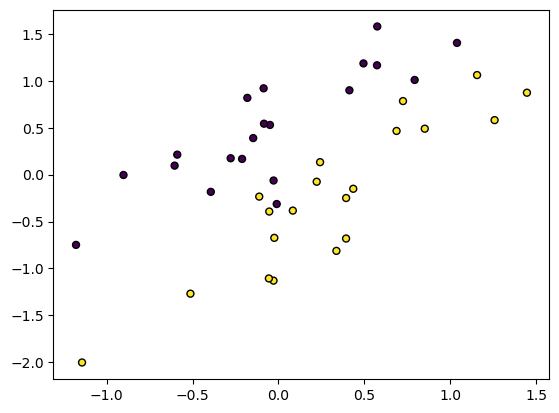

In [5]:
# Generating synthetic data
X, y = make_classification(
    n_samples=40, 
    n_features=2,
    class_sep=0.3, # Determine the separation of data
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=7
) # 2 classes by default
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")
linearlySeparable(X,y)
num_qubits=2

In [6]:
###  Linear kernel   ############################################################################################################################################################################################################

def lin_kernel(x: tuple, y: tuple)-> float:
    """ return the linear kernel for two data points

    Args:
        x (tuple): _description_
        y (tuple): _description_

    Raises:
        Exception: _description_

    Returns:
        float: _description_
    """
    if len(x)!=len(y):
        raise Exception('The lenght of the two data points is not the same')
        exit(1)
    a=np.array(x)
    b=np.array(y)
    
    return a.dot(b)
    

In [7]:
###  Kernel function   #########################################################################################################################################################################################################

def kernel(x,y)->float:
    
    Ker=lin_kernel(x,y)
    
    return Ker

### 2) - Choice of the margin $\gamma$

When the data set is not totally separable, it is possible to add a certain tolerance.

In [8]:
#gamma constant
gamma = 100

## `B - Expending F as` $\Gamma $

We want to trasnform $F$ in order to make the computation of $Fx$ suitable for quantum computing

### 1) - Creating $F$

We want $F$ to be of size $2^N$ in order to work with qubits, so we resize it in order to have $2^{N-1}<M+1<2^N$ by adding $2^N - M - 1$ trivial equations

In [9]:
#Number of qubits needed
num_qubits = int(np.ceil(np.log2(M+1)))

NameError: name 'M' is not defined

In [10]:
###  Kernel matrix   ###########################################################################################################################################################################################################

def K(data: list)->np.array:
    K=(1/gamma)*np.eye(M)
    for i in range(0,M):
        for j in range(0,M):
            K[i,j] += kernel(data[i],data[j])
    return K  

In [11]:
### F matrix ############################################################################################################################################################################################################################

F = np.zeros((pow(2,num_qubits),pow(2,num_qubits)))
F[1:M+1,0] = 1
F[0,1:M+1] = 1
F[1:(M+1),1:(M+1)] = K(data)        
F

NameError: name 'M' is not defined

### 2) - Computing the $U_{f_i}$

We now compute the coefficients $c_i$ such that $F=\sum\limits_{i=0}^{2^N-1}c_i\Gamma_i$ using an optimisation process and a variational universal‑quantum‑state generator.
To compute the $c_i$, we can notice that $c_i=Tr[F\Gamma_i]$.\
Let $f_q$ be the $q^{th}$ column of $F$, $q\in{\llbracket 0,2^N-1 \rrbracket}$, we have:
$c_i=Tr[F\Gamma_i]=\sum\limits_{q=0}^{2^N-1}\langle q|\Gamma_i|f_q\rangle$\

For an easier computation, we want to determine the $U_{f_q}$ such that $f_q=\lVert f_q\rVert U_{f_q}|f_q\rangle$

We use universal quantum gates and optimisation with this aim


*The universal quantum circuit for N qubits necessites at least $4^N-1$ parameters*

In [12]:
### Construct the variational quantum circuit given parameters   ################################################################################################################################################################

## TO MODIFY, this is not correct ##


def universalGate(parameters: list, num_qubits: int):
    """
    Generate the quantum circuit associated to the input parameters with num_qubits qubits. Any unitary transformation is approximable by this universalGate

    Args:
        parameters (list): Parameters of the Gate
        num_qubits (int): number of qubits of the gate

    Raises:
        Exception: _description_

    Returns:
        QuantumCircuit: quantum circuit correspondig to the unitary transformation
    """
    # Construct circuit
    L=len(parameters)
    
    # if L<=pow(4,num_qubits)-1:
    #     raise Exception('The number of parameters is not sufficient for the number of qubits')  #check if their is enough parameters to control all the qubits
    #     exit(1)
        
    circuit = QuantumCircuit(num_qubits) #create circuit
    
    for i in range(num_qubits):
        # Append first X rotation
        circuit.rx(parameters[i],i)
        # Append Z rotation
        circuit.rz(parameters[num_qubits+i],i)
        # Append second X rotation
        circuit.rx(parameters[2*num_qubits+i],i)
        # Append controlled Y rotation
        if(i!=0):
            circuit.cry(theta = parameters[3*num_qubits+i],control_qubit=i-1, target_qubit=i)
            
    # Add last controlled gate
    circuit.cry(theta = parameters[3*num_qubits],control_qubit=num_qubits-1, target_qubit=0)
    
    return circuit


We now use the created circuit to optimize the parameters and find the gate $U_{f_q}$

In [13]:
### Cost function for the optimization  #######################################################################################################################################################################################

#Given some parameters for a variational circuit and a state it returns the corresponding cost value

def costFunction(parameters, desiredState):
    circuit = universalGate(parameters,num_qubits)
    # Run the circuit over zero state
    outputState = Statevector(circuit)
    norm = np.linalg.norm(desiredState)
    #Compute the cost value
    costValue = np.abs(1 - outputState.inner(desiredState/norm))
    # print(f"Comparing {outputState} to {desiredState} with value: {costValue} and params: {parameters}")
    
    return costValue

In [14]:
### Optimization function  ######################################################################################################################################################################################################

def unitaryOptimization(f : np.array)-> list:
    """Generate the optimal list of parameters to compute the unitary matrix U_f_q such that U_f_q|0>=f_q

    Args:
        f (np.array): column f_q of the matrix F

    Returns:
        list: list of parameters for the universalGate function
    """
    if len(f) != pow(2,num_qubits):
        raise Exception('The lenght of the provided vector does not match the number of qubits')
    tol = 0.000001*1/np.linalg.norm(f)
    parameters = (np.random.rand(4*num_qubits)-0.5*np.ones(4*num_qubits))*np.pi
    # Optimize parameters
    optimization = sp.optimize.minimize(costFunction, parameters, method='powell', tol=tol, args=(f))
    return optimization

# returns the optimized parameters

### 3) Computation of the $c_i$

We start by getting a binary decomposition of q in order to compute the $U_{x}^{(q)}$ such that for $q\in{\llbracket 1,N \rrbracket}$ , $U_{x}^{(q)} = \bigotimes\limits_{n_i=1}^{2^N-1}\sigma_x^{(i)}$ and $U_{x}^{(q)}|0\rangle = \frac{1}{\lVert f_q \rVert}|f_q\rangle$.

In [15]:
### Binary decomposition  ##############################################################################################################################################################################################

def bin_dec(q : int, num_qubits : int)->list:
    """
    Return the decimal representation of the integer q on num_qubits bits

    Args:
        q (int): 
        num_qubits (int): 

    Returns:
        list: list of the binary representation from left to right
    """
    if q>pow(2,num_qubits)-1:
        warnings.warn('The integer q requires more qubits than specified to be written, it has been written on the needed number of qubits')
    fbits = str(num_qubits) + 'b'
    L=list(format(q,fbits))
    
    return [0 if i==' ' else int(i) for i in L]



In [21]:
qb = bin_dec(6,num_qubits)
print(qb)

[1, 1, 0]


In [16]:
### q - Unitary circuit  ##############################################################################################################################################################################################

def q_unitary(q : int, qc : QuantumCircuit, num_qubits)->int:
    """Add to the Quantum circuit qc the quantum Gate U_x^(q) which transform the state |0> into |q>, where |q> is the binary representation of q

    Args:
        q (int): 
        qc (QuantumCircuit): Quantum circuit to be modified

    Returns:
        int: 0 if successful
    """
    
    qb = bin_dec(q,num_qubits)
    for i in range(len(qb)):
        if qb[i] == 1:
            qc.x(num_qubits-i-1)
            
    return 0

Compute the $\Gamma_i$

Unknown choice for the $\Gamma_i$ of the form $\Gamma_i=\bigotimes\limits_{\beta=1}^N\sigma_\alpha^{(\beta)}$ with $\alpha\in{\{0,x,y,z\}}$.

Have to change the choice of gamma, each gamma_i needs to be different 

In [17]:
### Choice of the Gamma_i #######################################################################################################################################################################################################

def Gamma_i(i : int, circuit : QuantumCircuit, num_qubits : int)->list:
    """ Create and add the unitary transformation Gamma_i at the end of the Quantum circuit of size num_qubits

    Args:
        i (int): index of Gamma unitary
        circuit (QuantumCircuit): Quantum circuit on which the unitary Gamma_i is added
        num_qubits (int): size in qubits of Gamma_i and circuit

    Raises:
        Exception: _description_

    Returns:
        list: the list used to generate Gamma_i
    """
    
    n = circuit.num_qubits
    if n!=num_qubits:
        raise Exception('The Quantum circuit has {} qubits which is different from the input number of qubits {}'.format(n,num_qubits))
    #Choice of pauli matrices to apply
    #list of size n with values in 0,x,y,z
    ###TO WRITE
    Ch = [0,'x','y','z']
    P=[Ch[np.random.randint(0,4)] for k in range(n)]
    
    Gamma_build(P, circuit)   
            
    return P


def Gamma_build(P : list, circuit : QuantumCircuit = None, to_matrix = False)->int :
    """Given a list

    Args:
        P (list): list specifying the pauli matrix to apply to qubit i at index i (generator of Gamma_i)
        circuit (QuantumCircuit): Quantum circuit to implement the Gamma unitary on
        to_matrix (bool): If true, return the matrix of the unitary transformation of the final circuit

    Returns:
        int: 0 if success
        np.array: matrix of the unitary transformation of the circuit after implementing Gamma
    """
    if not to_matrix and not isinstance(circuit,QuantumCircuit) :
        raise Warning('An argument could be missing : "circuit" or "to_matrix"')
    
    if not isinstance(circuit,QuantumCircuit):
            circuit = QuantumCircuit(len(P)) 
    
    if len(P) != circuit.num_qubits:
        raise ValueError('The lenght of the list of transformations is not the same as the number of qubits of the circuit')
    for p in range(len(P)):
        if P[p] == 'x':
            circuit.x(p)
        elif P[p] == 'y':
            circuit.y(p)
        elif P[p] == 'z':
            circuit.z(p)
        elif P[p] == 0:
            circuit.id(p)
    
    if to_matrix:
        return np.array(Operator(circuit))
            
    return 0


def Gamma_matrix(P :list)->np.array:
    
    return Gamma_build(P,to_matrix=True)
    

In [24]:
# P=[0,0,'x']
# print(np.real(Gamma_matrix(P)).dot([1,0,0,0,0,0,0,0]))
qc = QuantumCircuit(2)
qc.x(0)
print(qc)
print(Statevector(qc).data)
q_unitary(2,qc,2)
print(qc)
print(Statevector(qc).data.dot([1,0,0,0]))


     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
0j


In [25]:
### test cell ###########################################
# out=[]
# for i in range(30):
#     param = unitaryOptimization(F[:,1])
#     out.append(Statevector(universalGate(param.x,num_qubits))*np.linalg.norm(F[:,1]))
    
# print(np.mean(out,0))
# print(num_qubits)
# print(F[:,1])
print(F)
f_q= F[:,2]
param = unitaryOptimization(f_q).x
qc = universalGate(param, num_qubits)
print(qc)
fq_tilde = Statevector(qc).data*np.linalg.norm(f_q)
print(f_q)
print(fq_tilde)
print(f_q-fq_tilde)
print(np.linalg.norm(f_q-fq_tilde))
# ds = np.zeros(pow(2,num_qubits))
# ds[0] = 1
# costFunction((np.random.rand(4*num_qubits)-0.5*np.ones(4*num_qubits))*np.pi,F[:,2])
# qc = universalGate(param,N)
# print('Initial vector is {} and result is {}'.format(F[:,2],Statevector(qc)))

# print(qc)
# Gamma_choice(2,qc,N)
# qc.draw('mpl')

[[  0.     1.     1.     1.     1.     0.     0.     0.  ]
 [  1.    89.01  61.    -7.     9.     0.     0.     0.  ]
 [  1.    61.    85.01 -25.    41.     0.     0.     0.  ]
 [  1.    -7.   -25.    10.01 -17.     0.     0.     0.  ]
 [  1.     9.    41.   -17.    29.01   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.  ]]


KeyboardInterrupt: 

In [18]:
# Function that returns the list with strings of Pauli basis for num_qubits
def createGammaBasis(num_qubits : int):
    Paulis = [0,'x','y','z']
    return list(itertools.product(Paulis, repeat=num_qubits))
# Function that elements the innecesary elements of Pauli Basis based on conditons
def deleteBasisElements(basis, matrixType: str) -> list:
    if matrixType=="sym":
        basis = [element for element in basis if element.count("y")%2 ==0]
    elif matrixType=="diag" and ("x" in element or "y" in element):
        basis = [element for element in basis if ("x" in element or "y" in element)]
    return basis



In [ ]:
basis = createGammaBasis(3)
print(basis)

[(0, 0, 0), (0, 0, 'x'), (0, 0, 'y'), (0, 0, 'z'), (0, 'x', 0), (0, 'x', 'x'), (0, 'x', 'y'), (0, 'x', 'z'), (0, 'y', 0), (0, 'y', 'x'), (0, 'y', 'y'), (0, 'y', 'z'), (0, 'z', 0), (0, 'z', 'x'), (0, 'z', 'y'), (0, 'z', 'z'), ('x', 0, 0), ('x', 0, 'x'), ('x', 0, 'y'), ('x', 0, 'z'), ('x', 'x', 0), ('x', 'x', 'x'), ('x', 'x', 'y'), ('x', 'x', 'z'), ('x', 'y', 0), ('x', 'y', 'x'), ('x', 'y', 'y'), ('x', 'y', 'z'), ('x', 'z', 0), ('x', 'z', 'x'), ('x', 'z', 'y'), ('x', 'z', 'z'), ('y', 0, 0), ('y', 0, 'x'), ('y', 0, 'y'), ('y', 0, 'z'), ('y', 'x', 0), ('y', 'x', 'x'), ('y', 'x', 'y'), ('y', 'x', 'z'), ('y', 'y', 0), ('y', 'y', 'x'), ('y', 'y', 'y'), ('y', 'y', 'z'), ('y', 'z', 0), ('y', 'z', 'x'), ('y', 'z', 'y'), ('y', 'z', 'z'), ('z', 0, 0), ('z', 0, 'x'), ('z', 0, 'y'), ('z', 0, 'z'), ('z', 'x', 0), ('z', 'x', 'x'), ('z', 'x', 'y'), ('z', 'x', 'z'), ('z', 'y', 0), ('z', 'y', 'x'), ('z', 'y', 'y'), ('z', 'y', 'z'), ('z', 'z', 0), ('z', 'z', 'x'), ('z', 'z', 'y'), ('z', 'z', 'z')]


In [19]:
def cjPauliBasis(num_qubits : int, F : np.array) -> list:

    # Creating our Pauli Basis
    gammas = createGammaBasis(num_qubits) 

    # Delete some innecesary elements from the basis if F meeting some conditions
    if (np.array_equal(F, np.diag(np.diag(F)))): # Check if F is diagonal (thus symmetric)
        gammas = deleteBasisElements(gammas, "diag")
    elif (F == F.transpose()).all(): # Check if F is symmetric
        gammas = deleteBasisElements(gammas, "sym")

    # Initialize elements
    c = np.zeros(len(gammas))
    # Creating the zero state vector needed
    zero_state = np.zeros(pow(2,num_qubits),dtype='complex')
    zero_state[0] = 1 #sate vector |0>
    zero_state = Statevector(zero_state)

    # Looping to get the coefficients
    for q in range(M+1):
        # Get the parameters for column q of F
        parameters = unitaryOptimization(F[:,q]).x
        for j in range(len(gammas)):

            # Creates the unitary for column q
            circuit = universalGate(parameters, num_qubits)
            # Add the corresponding gamma matrix
            Gamma_build(gammas[j], circuit)
            # Adding the X gates for q
            q_unitary(q, circuit, num_qubits)            
            print(circuit)

            # Applying the circuit to zero state
            outputState = Statevector(circuit)
            print(outputState)
            c[j]+= zero_state.inner(outputState)*np.linalg.norm(F[:,q])

    return c/2**num_qubits, gammas
    
        



In [ ]:
# Checking coefficients
c, gammas = cjPauliBasis(num_qubits, F)

     ┌─────────────┐┌─────────────┐┌─────────────┐                »
q_0: ┤ Rx(-1.9044) ├┤ Rz(-1.9836) ├┤ Rx(0.86078) ├────────■───────»
     └┬────────────┤└┬────────────┤├─────────────┤ ┌──────┴──────┐»
q_1: ─┤ Rx(1.3971) ├─┤ Rz(3.1331) ├┤ Rx(-1.7452) ├─┤ Ry(-1.9023) ├»
      ├────────────┤ ├────────────┤├─────────────┴┐└─────────────┘»
q_2: ─┤ Rx(1.5707) ├─┤ Rz(1.5706) ├┤ Rx(-0.92945) ├───────────────»
      └────────────┘ └────────────┘└──────────────┘               »
«                    ┌─────────────┐┌───┐
«q_0: ───────────────┤ Ry(-3.1357) ├┤ I ├
«                    └──────┬──────┘├───┤
«q_1: ───────■──────────────┼───────┤ I ├
«     ┌──────┴──────┐       │       ├───┤
«q_2: ┤ Ry(-1.5704) ├───────■───────┤ I ├
«     └─────────────┘               └───┘
Statevector([ 1.47871099e-03+1.17861900e-04j,
              5.00193693e-01+3.00241171e-04j,
              4.99552082e-01-5.36842589e-04j,
              5.00148474e-01-6.03859846e-05j,
              5.00102791e-01+2.96779224e-04j,


C:\Users\natha\AppData\Local\Temp\ipykernel_26596\3031209133.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  c[j]+= zero_state.inner(outputState)*np.linalg.norm(F[:,q])


Statevector([ 1.47871099e-03+1.17861900e-04j,
             -5.00193693e-01-3.00241171e-04j,
             -4.99552082e-01+5.36842589e-04j,
              5.00148474e-01-6.03859846e-05j,
             -5.00102791e-01-2.96779224e-04j,
              7.65433232e-08-1.16951977e-04j,
              4.53351301e-05-1.88787673e-06j,
              4.50123356e-05-1.91744972e-06j],
            dims=(2, 2, 2))
     ┌─────────────┐┌─────────────┐  ┌──────────────┐               »
q_0: ┤ Rx(-1.9505) ├┤ Rz(-1.5853) ├──┤ Rx(0.036842) ├───────■───────»
     └─┬──────────┬┘├─────────────┴┐ └┬────────────┬┘┌──────┴──────┐»
q_1: ──┤ Rx(1.75) ├─┤ Rz(0.034546) ├──┤ Rx(1.3915) ├─┤ Ry(-3.2634) ├»
     ┌─┴──────────┴┐├─────────────┬┘┌─┴────────────┴┐└─────────────┘»
q_2: ┤ Rx(0.20133) ├┤ Rz(-1.6036) ├─┤ Rx(0.0065308) ├───────────────»
     └─────────────┘└─────────────┘ └───────────────┘               »
«                    ┌────────────┐┌───┐┌───┐
«q_0: ───────────────┤ Ry(3.1647) ├┤ I ├┤ X ├
«                    

In [ ]:
# Calculating the "real" coefficients
C_j = [np.trace(F.dot(Gamma_matrix(gammas[i])))/pow(2, num_qubits) for i in range(len(gammas))]
print(f"Expected coefficients: {C_j}")
print(f"Given coeffficients: {c}")
print(f"Distance between them: {np.linalg.norm(C_j-c)}")

# Reconstructing matrix F
F_tilde_Approx = sum([c[i]*Gamma_matrix(gammas[i]) for i in range(len(gammas))])
print(f"Reconstructed F with ours coefficents: {(np.array_str(np.real(F_tilde_Approx), precision=2, suppress_small=True))}")
print(np.real(F))
print(f"Distance between real F and Approx: {np.linalg.norm(F-F_tilde_Approx)}")


Expected coefficients: [(26.75+0j), (0.25+0j), (19.4375+0j), (-1.5+0j), (10.25+0j), (-1.5+0j), (10.25+0j), (2.875+0j), (0.25+0j), (-4.4375+0j), (-6+0j), (2.25+0j), (-6+0j), (15.5+0j), (-4.25+0j), (15.5+0j), (-4.25+0j), (6.5+0j), (2.25+0j), (6.5+0j), (2.25+0j), (-4.25+0j), (15+0j), (4.25+0j), (15+0j), (2.25+0j), (1.875+0j), (0.25+0j), (-5.4375+0j), (2+0j), (10.25+0j), (2+0j), (10.25+0j), (-16.875+0j), (0.25+0j), (-24.1875+0j)]
Given coeffficients: [ 26.70219848   0.19802409  19.39492735  -1.3710392   10.2659539
  -1.37091177  10.2695496    2.92487343   0.19762458  -4.3823977
  -6.01191883   2.26122961  -6.01191762  15.54781748  -4.29894711
  15.54819083  -4.29855124   6.51974388   2.25999954   6.51974509
   2.26000348  -4.20067976  15.03451674   4.2003289   15.03414339
   2.26122559   1.82080055   0.19801765  -5.48647058   2.13081331
  10.26952749   2.13094075  10.26588646 -16.83185149   0.19763172
 -24.13912262]
Distance between them: 0.34206082279863226
Reconstructed F with ours coeff

Construction of the final Quantum circuit to compute $c_i$

*Following the lessons, the decomposition is efficient if we know some $c_i$ to be small so it is not necessary to compute every $c_i$.\
Moreover, the gradient descent method to be implemented after maybe more efficient if we use the shift rules, ie compute some eigen values*

In [ ]:
### Quantum circuit c_j  #######################################################################################################################################################################################################

def QC_cj(num_qubits : int, F :np.array)->list:
    
    #Initialisations
    c=np.zeros(pow(2,num_qubits),dtype='complex') #list of c_j
    
    zero_state = np.zeros(pow(2,num_qubits),dtype='complex')
    zero_state[0] = 1 #sate vector |0>
    zero_state = Statevector(zero_state)
    
    
    Gamma = []
    
    #Parsing over the q combinations
    for q in range(M+1):
        #computing the unitary transformation for f_q
        parameters = unitaryOptimization(F[:,q]).x
            
        #Parsing over the i
        for i in range(pow(2,num_qubits)): # Only going to M+1 because after the column is 0 and we cannot maps |0> to 0
            
            circuit = universalGate(parameters, num_qubits)
            if q == 0: 
                Gamma.append(Gamma_i(i, circuit, num_qubits)) #Applying Gamma_i and stock the generator in Gamma
            else:
                Gamma_build(Gamma[i], circuit)
            q_unitary(M-q, circuit, num_qubits)
            print(circuit)
            outputState = Statevector(circuit)
            print(outputState)
            c[i]+= zero_state.inner(outputState)*np.linalg.norm(F[:,q])
        
                       
    return c, Gamma

In [ ]:
c, Gamma = QC_cj(num_qubits, F)

      ┌────────────┐ ┌────────────┐ ┌────────────┐                »
q_0: ─┤ Rx(1.6812) ├─┤ Rz(1.0553) ├─┤ Rx(1.3623) ├────────■───────»
      ├────────────┤ ├────────────┤┌┴────────────┴┐┌──────┴──────┐»
q_1: ─┤ Rx(2.9584) ├─┤ Rz(2.9444) ├┤ Rx(-0.18251) ├┤ Ry(-1.8763) ├»
     ┌┴────────────┤┌┴────────────┤├─────────────┬┘└─────────────┘»
q_2: ┤ Rx(-1.5708) ├┤ Rz(-1.5684) ├┤ Rx(-1.5836) ├────────────────»
     └─────────────┘└─────────────┘└─────────────┘                »
«                    ┌─────────────┐┌───┐     
«q_0: ───────────────┤ Ry(-3.1164) ├┤ X ├─────
«                    └──────┬──────┘├───┤     
«q_1: ───────■──────────────┼───────┤ Y ├─────
«     ┌──────┴──────┐       │       ├───┤┌───┐
«q_2: ┤ Ry(-1.5732) ├───────■───────┤ X ├┤ X ├
«     └─────────────┘               └───┘└───┘
Statevector([-7.78178719e-05-4.99897287e-01j,
             -2.77236719e-03-4.98810960e-01j,
             -1.42615600e-03+4.99990514e-01j,
             -4.63529287e-04+6.28913458e-03j,
           

In [ ]:
C_i = [np.trace(F.dot(Gamma_matrix(Gamma[i]))) for i in range(len(Gamma))]
print(C_i)
print(c)
print(np.linalg.norm(C_i-c))

[0j, 0j, 0j, (124+0j), 0j, (-48+0j), (2+0j), 0j]
[-6.46317507e-02 +7.75108417j -1.59163187e-01+39.1711736j
  1.41311478e-01-29.23711935j  2.00929645e+01 +0.29386243j
  3.67583638e-01-17.7524378j   4.48643516e+01 +0.15547469j
  2.92583942e+01 +0.36477616j -3.20030906e-02+77.02325577j]
169.88498858107042


In [ ]:
F_tilde = sum([C_i[i]*Gamma_matrix(Gamma[i]) for i in range(len(Gamma))])
print(np.real(F_tilde))
print(F)
print(np.linalg.norm(F-F_tilde))

[[   0.  -48.    0.  124.    2.    0.    0.    0.]
 [ -48.    0.  124.    0.    0.   -2.    0.    0.]
 [   0.  124.    0.  -48.    0.    0.    2.    0.]
 [ 124.    0.  -48.    0.    0.    0.    0.   -2.]
 [   2.    0.    0.    0.    0.   48.    0. -124.]
 [   0.   -2.    0.    0.   48.    0. -124.    0.]
 [   0.    0.    2.    0.    0. -124.    0.   48.]
 [   0.    0.    0.   -2. -124.    0.   48.    0.]]
[[  0.     1.     1.     1.     1.     0.     0.     0.  ]
 [  1.    89.25  61.    -7.     9.     0.     0.     0.  ]
 [  1.    61.    85.25 -25.    41.     0.     0.     0.  ]
 [  1.    -7.   -25.    10.25 -17.     0.     0.     0.  ]
 [  1.     9.    41.   -17.    29.25   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.  ]]
367.69246660762576


In [ ]:
### STEPEST DESCENT METHOD ###     Depreciated

def exponentialEta(xi1, xi2, t):
    return xi1*np.exp(-xi2*t)

def steepestMethod(labels, fMatrix, xi1, xi2, deltaT, num_qubits, tol=10**-3):
    # Modifying labels for out desired output State
    desiredState = np.zeros(2**num_qubits)
    desiredState[1:len(labels)+1] = labels
    desiredState = (desiredState/np.linalg.norm(desiredState))
    # Generate random trial state 
    state = np.random.rand(2**num_qubits)*2*np.pi
    # Normalize trial state
    state = (state/np.linalg.norm(state)).astype(np.complex_)
    # Initialize costValues
    costFunctionUpdate = np.zeros(2**num_qubits)
    gradientCostFunction = np.ones(2**num_qubits)
    errorList = []
    error = 1 - np.abs(np.conjugate(state)@desiredState)**2
    prevCostValues = np.ones(2**num_qubits)*error
    # Initialize number of steps
    n = 0
    # We will perform the optimization until the change in the state is less than tol
    while np.abs(error)> tol and n<500000:
        t = n*deltaT # Discretization of time step
        eta = exponentialEta(xi1, xi2, t)  
        prevCostValues = np.copy(costFunctionUpdate) 
        for p in range(2**num_qubits):
            canonicVector = np.zeros(2**num_qubits)
            canonicVector[p] = 1
            # Small increase of State
            auxState = state + canonicVector*eta 
            # Calculate output state
            outputState = fMatrix @ auxState
            outputState /= np.linalg.norm(outputState)
            #### CHECK NORM OF THE INNER PRODUCT and ABS should be norm of inside####
            costFunctionUpdate[p] = 1-np.abs(np.conjugate(outputState)@desiredState)**2 
        # Calculate gradient of Cost Function
        if n==0:
            gradientCostFunction = costFunctionUpdate 
        else:
            gradientCostFunction = costFunctionUpdate - prevCostValues
        # Update our state in the gradient direction
        state += gradientCostFunction
        state /= np.linalg.norm(state)
        error = np.abs(1 - np.abs(np.conjugate(state)@desiredState)**2)
        print(error)
        errorList.append(error)
        n += 1
    return state, errorList

In [20]:
### STEPEST DESCENT METHOD ################################################################################################################################################################


def SDM(labels : np.array, num_qubits :int, Xi: tuple, delta_t : float, F_tilde = None, c_j : list = None, Gammas : np.array =None, X0 = None ):

    M = len(labels)
    desiredState = np.zeros(2**num_qubits)
    desiredState[1:M+1] = labels
    

    if not isinstance(F_tilde, np.ndarray) :
        raise Exception("Missing argument c_j or F_tilde")

    #Initialisation
    if isinstance(X0,np.ndarray):
        state = X0
    else:
        state = np.zeros(2**num_qubits)
        state[0:M+1] = np.random.rand(M+1)*10 - np.random.rand(M+1)*10
    
    state/=np.linalg.norm(state)
    eta = Xi[0]
    delta = gradient(state,desiredState,eta, F_tilde)
    delta_cost = cost_gradient(state,desiredState, F_tilde)
    print(delta_cost)
    n=0
    error_grad =[delta_cost]
    while delta_cost>0.02 and n<10000 :
        eta = Xi[0]*np.exp(-Xi[1]*n*delta_t)
        delta = gradient(state, desiredState, eta, F_tilde)
        state-= eta*delta
        state /=np.linalg.norm(state)
        delta_cost = cost_gradient(state,desiredState, F_tilde)
        error_grad.append(delta_cost)
        n+=1
        print(delta_cost)
        
    return state, error_grad

def gradient(state :np.array, desiredState :np.array, eta : float, F_tilde :np.array):
    future = np.copy(state)
    cost = cost_gradient(future, desiredState,F_tilde)
    gradient = np.zeros(len(future))
    for p in range(len(future)):
        future = add_eta(p, future, eta)
        cost_future = cost_gradient(future, desiredState,F_tilde)
        gradient[p]+= cost_future - cost
    return gradient


def apply_F_matrix(state : np.array, C_j : list = None, Gammas : np.ndarray = None, F_tilde = None):
    
    if isinstance(F_tilde, np.ndarray):
        return Statevector(F_tilde@state)
    elif isinstance(C_j,list):
        param = unitaryOptimization(state)
        qc = universalGate(param, num_qubits)
        Psi = Statevector(qc)
        return Psi
        
        
        
    

def cost_gradient(state :np.array, outstate : np.array, F_tilde : np.array):
    oustate = Statevector(outstate)
    n_out = np.linalg.norm(oustate.data)
    future = apply_F_matrix(state, F_tilde= F_tilde)
    n_future = np.linalg.norm(future.data)
    return np.abs(1-future.inner(outstate)/(n_future*n_out))



def add_eta(p : int,state : np.array, eta : float)-> np.array:
    future = np.copy(state)
    future[p]+=eta
    return future




In [51]:
data = [[0.64,-3.2],[17.64,12.08],[-22,0.12],[-1.2,-8.7]]
M = 4
num_qubits = math.ceil(np.log2(M+1)) # Number of needed qubits with M+1 (adding the row/column)
F_shape = 2**num_qubits
extraEquations = M - F_shape

### Creating F matrix ####
F = np.zeros((pow(2,num_qubits),pow(2,num_qubits)))
F[1:M+1,0] = 1
F[0,1:M+1] = 1
F[1:(M+1),1:(M+1)] = K(data)  
F_Reconstructed = np.zeros_like(F)
for q in range(M+1):
    parameters = unitaryOptimization(F[:,q]).x
    # Creates the unitary for column q
    circuit = universalGate(parameters, num_qubits)
    state = Statevector(circuit)
    F_Reconstructed[:,q] = state.data*np.linalg.norm(F[:,q])

KeyboardInterrupt: 

In [ ]:
print(f"Reconstructed F with ours coefficents\n: {(np.array_str(np.real(F_Reconstructed), precision=2, suppress_small=True))}")


Reconstructed F with ours coefficents
: [[   0.01    0.94   -6.62   -2.43    4.12    0.      0.      0.  ]
 [   1.     10.91  -35.6   -16.49   26.69    0.      0.      0.  ]
 [   1.    -27.37  455.13 -386.63 -125.22    0.      0.      0.  ]
 [   1.    -14.46 -388.96  484.86   25.79    0.      0.      0.  ]
 [   1.     27.07 -124.64    1.41   78.95    0.      0.      0.  ]
 [   0.      0.      0.01    0.      0.32    0.      0.      0.  ]
 [   0.      0.     -0.02    0.01   -0.      0.      0.      0.  ]
 [  -0.     -0.      0.03    0.01   -0.      0.      0.      0.  ]]
[[ 0.          1.          1.         ...  0.          0.
   0.        ]
 [ 1.          5.23728055 -1.68516139 ...  0.          0.
   0.        ]
 [ 1.         -1.68516139  1.53736153 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.        

### Separation

In [54]:
# Split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test
M = X_train.shape[0] # Number of data points
#M = 4
num_qubits = math.ceil(np.log2(M+1)) # Number of needed qubits with M+1 (adding the row/column)
F_shape = 2**num_qubits
extraEquations = M - F_shape

### Creating F matrix ####
F = np.zeros((pow(2,num_qubits),pow(2,num_qubits)))
F[1:M+1,0] = 1
F[0,1:M+1] = 1
F[1:(M+1),1:(M+1)] = K(X_train)  

### Gamma matrix expansion of F ###
c, gammas = cjPauliBasis(num_qubits, F)

### Reconstructing F ###
F_tilde_Approx = sum([c[i]*Gamma_matrix(gammas[i]) for i in range(len(gammas))])
print(f"Reconstructed F with ours coefficents: {(np.array_str(np.real(F_tilde_Approx), precision=2, suppress_small=True))}")
print(np.real(F))
print(f"Distance between real F and Approx: {np.linalg.norm(F-F_tilde_Approx)}")

      ┌────────────┐┌─────────────┐┌──────────────┐                 »
q_0: ─┤ Rx(-1.671) ├┤ Rz(-1.5168) ├┤ Rx(-0.49267) ├────────■────────»
      ├────────────┤└┬────────────┤├─────────────┬┘┌───────┴───────┐»
q_1: ─┤ Rx(1.6095) ├─┤ Rz(1.5599) ├┤ Rx(0.27568) ├─┤ Ry(-0.043555) ├»
     ┌┴────────────┤┌┴────────────┤├─────────────┴┐└───────────────┘»
q_2: ┤ Rx(-1.5821) ├┤ Rz(-1.5624) ├┤ Rx(-0.63897) ├─────────────────»
     └┬────────────┤└┬────────────┤├──────────────┤                 »
q_3: ─┤ Rx(1.6296) ├─┤ Rz(1.6464) ├┤ Rx(-0.90849) ├─────────────────»
      ├────────────┤ ├────────────┤├─────────────┬┘                 »
q_4: ─┤ Rx(1.6785) ├─┤ Rz(1.5492) ├┤ Rx(0.19726) ├──────────────────»
      └────────────┘ └────────────┘└─────────────┘                  »
«                                                    ┌──────────────┐┌───┐
«q_0: ───────────────────────────────────────────────┤ Ry(-0.21479) ├┤ I ├
«                         ┌───┐                      └──────┬───────┘└───┘
«q_1:

C:\Users\natha\AppData\Local\Temp\ipykernel_9820\3031209133.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  c[j]+= zero_state.inner(outputState)*np.linalg.norm(F[:,q])


Statevector([-0.1196431 -6.26091717e-07j, -0.11054686-7.00480751e-07j,
             -0.11052652-2.45001945e-07j, -0.09777607-3.25908575e-07j,
              0.15361805+3.07617689e-07j,  0.14193876+4.40860994e-07j,
              0.175153  -1.86812006e-07j,  0.15494717+7.74262780e-09j,
             -0.22483794-6.26441473e-07j, -0.20774393-8.08061896e-07j,
             -0.20770572+4.77980042e-08j, -0.18374457-1.62873107e-07j,
              0.1811773 -5.93094810e-08j,  0.16740274+1.29930359e-07j,
              0.20657565-7.01614492e-07j,  0.18274486-4.16634621e-07j,
              0.15287116+4.68260863e-07j,  0.17518034+7.31097569e-07j,
              0.14188778+7.25971732e-09j,  0.15566268+1.81210666e-07j,
             -0.19628186+3.28581655e-08j, -0.22492616-2.12080334e-07j,
             -0.22485165+7.26738431e-07j, -0.24668094+5.22746708e-07j,
              0.18029989+1.31213246e-07j,  0.20661187+3.79761229e-07j,
              0.16734584-3.82250160e-07j,  0.18359228-2.15029531e-07j,
      

In [ ]:
### Optimizing parameters of the hyperplane ###
state, errorList = SDM(y_train,num_qubits,(1.72083683, 0.05122294),0.01,F_tilde_Approx)
plt.plot(range(len(errorList)), errorList)
plt.yscale("log")
state = state.astype(np.float64)
print(state)



NameError: name 'SDM' is not defined

In [ ]:
### Calculating the hyperplane ###
def hyperplane(state, data):
    w = np.zeros(data.shape[1])
    w0 = state[0]
    alphas = state[1:data.shape[0]+1]
    for j in range(data.shape[0]):
        w += alphas[j]*data[j]
    return w, w0
def classificationPoint(w, w0, point):
    classification = w @ point + w0
    return 0 if classification>0 else 1

NameError: name 'c' is not defined

[ 0.69060013 -0.29647757]
[1 0 1 0 1 1 1 1 1 1 0 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
0.0 %


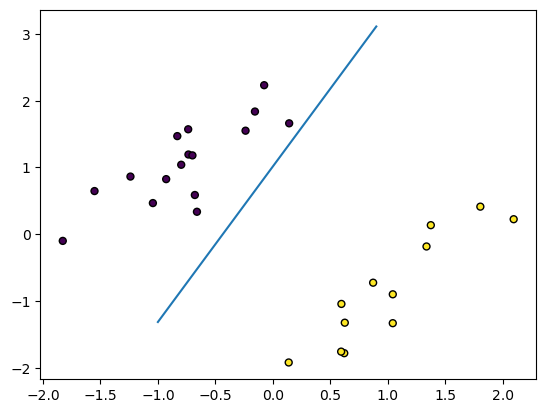

In [ ]:
### Calculate hyperplane and bias ###
w, w0 = hyperplane(state, X_train)
print(w)
### Make predictions ###
predictions = []
for point in X_test:
    predictions.append(classificationPoint(w, w0, point))
### Check performance ###
print(y_test)
print(predictions)
equalLabel = (np.array(predictions)+np.array(y_test))%2 # Add them to see which ones have equal label in modulo 2
accuracy = np.count_nonzero(equalLabel==0)/len(y_test)
print(f"{accuracy*100} %")
plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, s=25, edgecolor="k")
x = np.arange(-1,1, 0.1)
plt.plot(x,[-(xi*w[0] + w0)/w[1] for xi in x])


In [ ]:
[ 0.3060243 +0.j  0.06065944+0.j -0.01849677+0.j  0.54526151+0.j
  0.26265629+0.j  0.49245136+0.j  0.06482704+0.j  0.46132873+0.j]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (296257146.py, line 1)

NameError: name 'state' is not defined

In [ ]:
# Comparative Analysis for classical SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test

#Create a svm Classifier
clf = svm.SVC(C=100,kernel='linear') # C is the hyperparameter to optimize Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

NameError: name 'svm' is not defined

In [ ]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=10, entanglement="linear")
print(adhoc_feature_map)
sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(X_train, y_train)

qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")


In [ ]:
# # Set up
# M = X.shape[0] # Number of data points
# M = 4
# num_qubits = math.ceil(np.log2(M+1)) # Number of needed qubits with M+1 (adding the row/column)
# F_shape = 2**num_qubits
# extraEquations = M - F_shape
# # Creating Kernel matrix depending on gamma
# gamma = 1 # Soft margin 
# K = np.zeros((M,M))
# for i in range(M):
#     for j in range(M):
#         K[i][j] = np.dot(X[i],X[j])
# # Building F matrix
# F = np.zeros((F_shape,F_shape))
# F[1:(M+1),0] = 1
# F[0,1:(M+1)] = 1
# F[0,0] = 0
# F[1:(M+1),1:(M+1)] = K + np.eye(M)/gamma
# print(F)
# columnVectors = []
# for i in range(M):
#     columnVectors.append(Statevector(F[:,i]))
# # Construct universal gates for each of the column vectors of F
# unitaryList = []
# for f in columnVectors:
#     optimization = unitaryOptimization(f)
#     parametersOpt = optimization.x
#     costValues = optimization.fun

